In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from yellowbrick.cluster import silhouette_visualizer

import warnings
warnings.filterwarnings("ignore")

**1. Подготовим данные**

In [175]:
df = pd.read_excel('rfm_data.xlsx')

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417495 entries, 0 to 417494
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             417495 non-null  datetime64[ns]
 1   user_session_id  417495 non-null  object        
 2   cnt_help_pages   417495 non-null  int64         
 3   user_company_id  417495 non-null  object        
 4   user_client_id   417495 non-null  object        
 5   user_role        417495 non-null  object        
 6   theme            342135 non-null  object        
 7   cnt_tickets      416684 non-null  float64       
 8   amount           416684 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 28.7+ MB


**a. Заменим null на 0 и на строку "Не определена"**

In [177]:
df['theme'] = df['theme'].fillna('Не определена')
df['cnt_tickets'] = df['cnt_tickets'].fillna(0)
df['amount'] = df['amount'].fillna(0)

**б. Приведём данные к нужному формату** 

In [178]:
df['date'] = df['date'].dt.date
df['cnt_tickets'] = df['cnt_tickets'].astype('int64')
df['amount'] = df['amount'].astype('int64')

In [179]:
print('Данные за период: от {} до {}'.format(df['date'].min(), df['date'].max()))
print('Количество уникальных пользователей: {}'.format(df['user_client_id'].nunique()))
print('Количество уникальных компаний: {}'.format(df['user_company_id'].nunique()))
print('Количество заходов в раздел Помощь: {}'.format(len(df)))
print('Количество сообщений в поддержку: {}'.format(df['cnt_tickets'].sum()))
print('Сумма, потраченная на поддержку : {} руб.'.format(df['amount'].sum()))

Данные за период: от 2022-06-15 до 2022-08-31
Количество уникальных пользователей: 84541
Количество уникальных компаний: 80540
Количество заходов в раздел Помощь: 417495
Количество сообщений в поддержку: 1286610
Сумма, потраченная на поддержку : 128661000 руб.


**2. Вычислим и визуализируем метрики RFM: recency, frequency, monetary**

In [180]:
max_date = df['date'].max() + dt.timedelta(days=1)
df_rfm = df.groupby('user_client_id').agg({'date': lambda x: (max_date - x.max()).days, 
                                           'user_company_id': 'count',
                                           'amount': 'sum'})
df_rfm.columns=['recency', 'frequency', 'monetary']

In [181]:
df_rfm

,recency,frequency,monetary
user_client_id,,,
0001f3785a0a25569cde27e7f28f79dba66ca222,30,4,1500
000243ad0488a501cd994670cc12fa7ae4edcde9,28,5,800
00026c5cdb25e2b03e3ce2f966614c026024a86b,10,8,1700
000292735f714ba59c54d293f5725b32fbd91b7c,21,1,200
000297d8792259c0d1068ad4aa7abf8a200b8806,51,1,100
...,...,...,...
fffc450c8d9a7e5ab49c6653ae820908a59373df,8,2,400
fffe04bb9366c0759a7ce6b807f6c737acb01e47,1,2,200
fffea59299f17b952db19dbd3e2a34c889ac4751,9,2,1900


<AxesSubplot:xlabel='recency', ylabel='Density'>

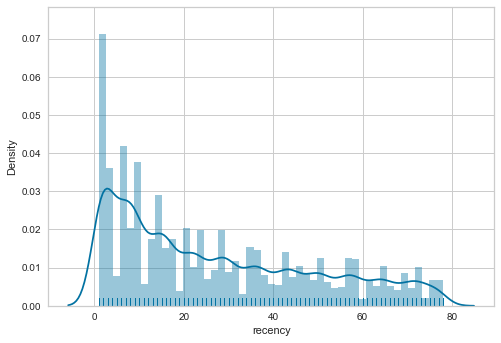

In [170]:
sns.distplot(df_rfm['recency'], hist=True, rug=True)

<AxesSubplot:xlabel='frequency', ylabel='Density'>

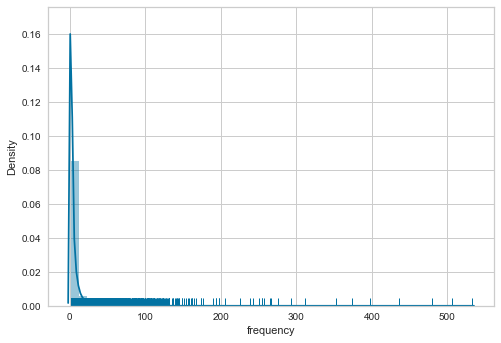

In [171]:
sns.distplot(df_rfm['frequency'], hist=True, rug=True)

<AxesSubplot:xlabel='monetary', ylabel='Density'>

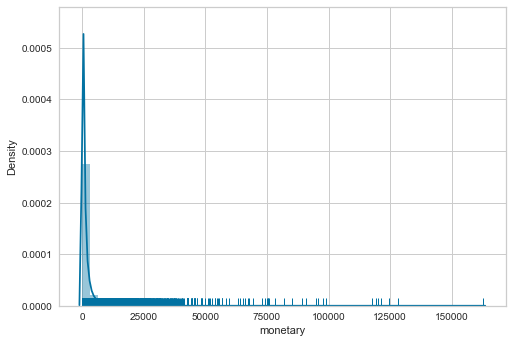

In [172]:
sns.distplot(df_rfm['monetary'], hist=True, rug=True)

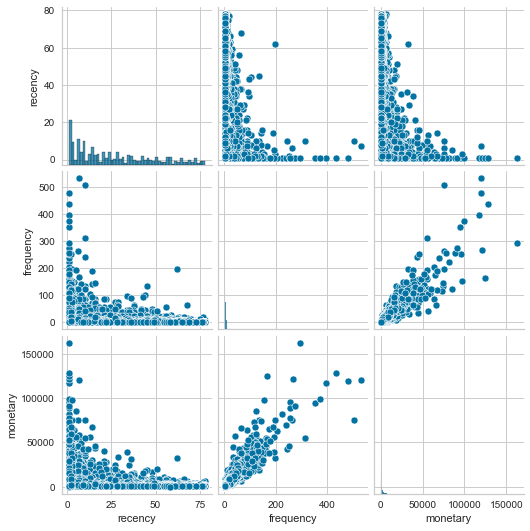

In [163]:
# Посмотрим на графике pairplot отношения между всеми парами метрик

sns.pairplot(df_rfm)

In [55]:
display(df_rfm.describe())

,recency,frequency,monetary
count,84541.000000,84541.000000,84541.000000
mean,26.821081,4.938373,1521.876959
std,22.198770,10.146599,3341.916702
min,1.000000,1.000000,0.000000
25%,8.000000,1.000000,300.000000
50%,21.000000,2.000000,600.000000
75%,43.000000,5.000000,1500.000000
max,78.000000,532.000000,162500.000000


<AxesSubplot:>

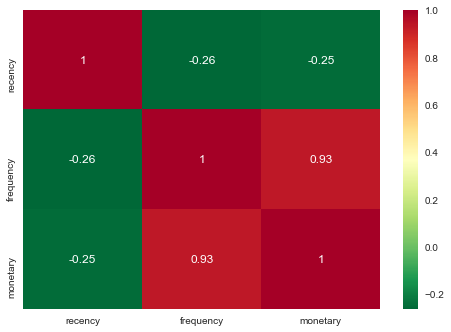

In [164]:
sns.heatmap(df_rfm.iloc[:, 0:3].corr(), annot=True, cmap='RdYlGn_r') 

**3. Нормализуем данные. Это шаг необходим, чтобы избежать переобучения модели**

In [182]:
scaler = MinMaxScaler()

rfm_norm = pd.DataFrame(scaler.fit_transform(df_rfm.iloc[:, 0:3]))
rfm_norm.columns=['n_recency', 'n_frequency', 'n_monetary']
rfm_norm

,n_recency,n_frequency,n_monetary
0,0.376623,0.005650,0.009231
1,0.350649,0.007533,0.004923
2,0.116883,0.013183,0.010462
3,0.259740,0.000000,0.001231
4,0.649351,0.000000,0.000615
...,...,...,...
84536,0.090909,0.001883,0.002462
84537,0.000000,0.001883,0.001231
84538,0.103896,0.001883,0.011692
84539,0.012987,0.005650,0.009846


In [183]:
rfm_norm.describe()

,n_recency,n_frequency,n_monetary
count,84541.000000,84541.000000,84541.000000
mean,0.335339,0.007417,0.009365
std,0.288296,0.019108,0.020566
min,0.000000,0.000000,0.000000
25%,0.090909,0.000000,0.001846
50%,0.259740,0.001883,0.003692
75%,0.545455,0.007533,0.009231
max,1.000000,1.000000,1.000000


**4. Определим оптимальное число центроидов кластеров (k)**

<AxesSubplot:>

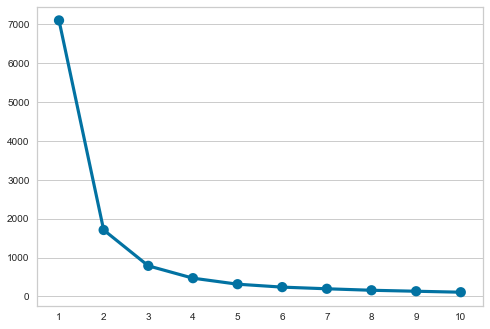

In [16]:
SSE = []

for k in range(0,10):
    kmeans = KMeans(n_clusters=k+1, random_state=1231).fit(rfm_norm)
    SSE.append(kmeans.inertia_)
    
sns.pointplot(x=list(range(1,11)), y=SSE)

**Вывод:** на графике видно, что SSE падает сильно при увеличении числа кластеров с 1 до 2 и с 2 до 3 и уже не так сильно – при изменении k с 3 до 4. Значит, в данной задаче оптимально задать 3 кластера (k=3).

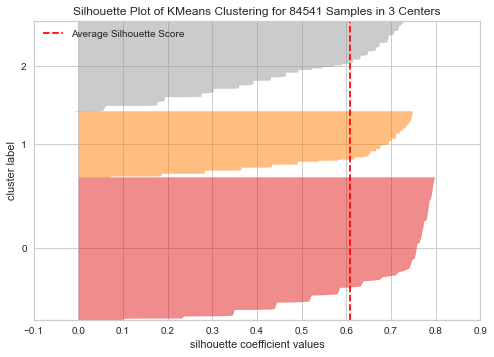

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 84541 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=3, random_state=42))

In [184]:
# https://scikit-learn.org/0.24/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Посмотрим на график анализа силуета. График силуэта показывает, что значения n_clusters = 3 - правильный выбор, потому что
# нет кластеров с коэффициентом силуета  ниже среднего. Колебания в размере графиков силуэтов также приемлемы.
silhouette_visualizer(KMeans(3, random_state=42), rfm_norm)

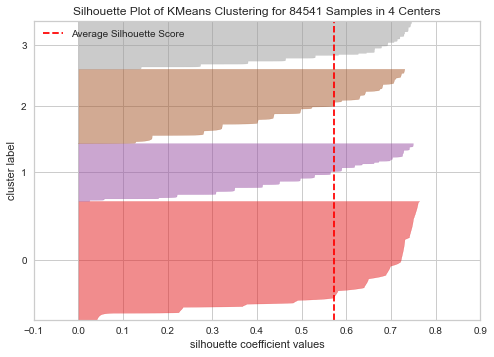

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 84541 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [185]:
# Проведём анализ силуетов кластеров и для n_clusters = 4. График показывает также качественное разбиение на кластера. 
# Кластер 0 стал меньше.
silhouette_visualizer(KMeans(4, random_state=42), rfm_norm)

**Построим 2 модели и выберем лучшую**

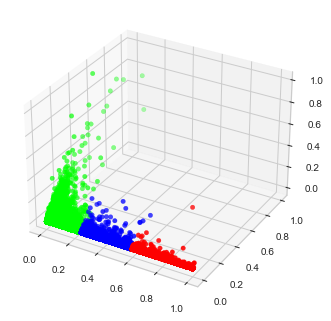

In [194]:
# Точечная диаграмма для n_clusters=3
model = KMeans(n_clusters=3, random_state=1231).fit(rfm_norm)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_norm['n_recency'], rfm_norm['n_frequency'], rfm_norm['n_monetary'], cmap='brg',
          c=model.predict(rfm_norm))
ax.scatter(centers[:,0], centers[:,1], c='black');

**5. Рассмотрим получившиеся кластеры**

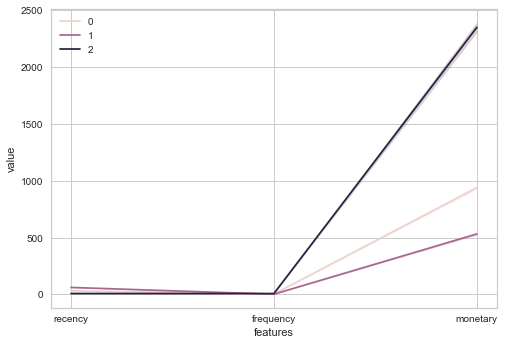

In [195]:
rfm_3 = pd.DataFrame(scaler.inverse_transform(rfm_norm))
rfm_3.columns = ['recency', 'frequency', 'monetary']
rfm_3['user_client_id'] = df_rfm.index
rfm_3['cluster'] = model.labels_

melted_rfm_norm = pd.melt(rfm_3.reset_index(),
                         id_vars=['user_client_id', 'cluster'],
                         value_vars=['recency', 'frequency', 'monetary'],
                         var_name='features',
                         value_name='value')

sns.lineplot('features', 'value', hue='cluster', data = melted_rfm_norm)
plt.legend()

In [236]:
rfm_3.groupby('cluster').agg({
    'recency': ['mean', 'max', 'min'],
    'frequency': ['mean', 'max', 'min'],
    'monetary': ['mean', 'max', 'min', 'count']
})

recency             frequency                 monetary            \
              mean   max   min      mean    max  min         mean       max   
cluster                                                                       
0        31.646106  46.0  20.0  3.110928  136.0  1.0   938.214636   40500.0   
1        61.286051  78.0  47.0  1.763872  197.0  1.0   531.729895   32400.0   
2         7.818391  20.0   1.0  7.561820  532.0  1.0  2348.777467  162500.0   

                       
           min  count  
cluster                
0        100.0  25485  
1          0.0  18689  
2          0.0  40367

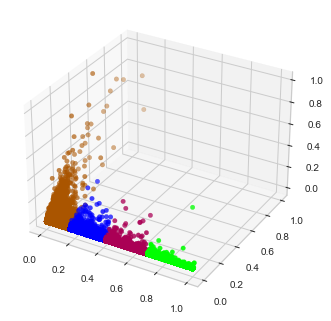

In [197]:
# Точечная диаграмма для n_clusters=4
model = KMeans(n_clusters=4, random_state=1231).fit(rfm_norm)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_norm['n_recency'], rfm_norm['n_frequency'], rfm_norm['n_monetary'], cmap='brg',
          c=model.predict(rfm_norm))
ax.scatter(centers[:,0], centers[:,1], c='black');

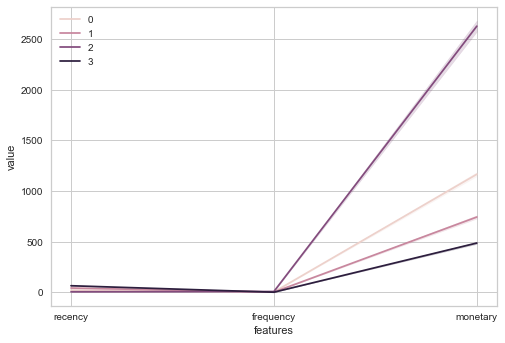

In [198]:
rfm_4 = pd.DataFrame(scaler.inverse_transform(rfm_norm))
rfm_4.columns = ['recency', 'frequency', 'monetary']
rfm_4['user_client_id'] = df_rfm.index
rfm_4['cluster'] = model.labels_

melted_rfm_norm = pd.melt(rfm_4.reset_index(),
                         id_vars=['user_client_id', 'cluster'],
                         value_vars=['recency', 'frequency', 'monetary'],
                         var_name='features',
                         value_name='value')

sns.lineplot('features', 'value', hue='cluster', data = melted_rfm_norm)
plt.legend()

In [199]:
rfm_4.groupby('cluster').agg({
    'recency': ['mean', 'max', 'min'],
    'frequency': ['mean', 'max', 'min'],
    'monetary': ['mean', 'max', 'min', 'count']
})

recency             frequency                 monetary            \
              mean   max   min      mean    max  min         mean       max   
cluster                                                                       
0        21.872678  32.0  14.0  3.828614  145.0  1.0  1165.292096   45500.0   
1        42.813070  54.0  33.0  2.498501  136.0  1.0   743.278468   38800.0   
2         5.607436  14.0   1.0  8.427249  532.0  1.0  2625.979277  162500.0   
3        65.479746  78.0  55.0  1.613886  197.0  1.0   486.733565   32400.0   

                       
           min  count  
cluster                
0        100.0  22989  
1        100.0  16343  
2          0.0  31656  
3          0.0  13553

**Выводы:** 
- алгоритм более точно делит пользователей с количеством кластеров = 4.
- пользователи делятся на 2 чёткие группы:
    - Активные пользователи (кластеры 2 (самые активные) и кластер 0): пользователи регулярно заходят в "Помощь" в течение последнего месяца. Очень часто - в среднем 8 раз. Однако они не только читают "Помощь", но и обращаются в поддержку - траты на обработку обращений от них самые высокие (в среднем 2626 рублей). Это наши активные пользователи. Возможно, что это так же и наши постоянные пользователи, которые регулярно пользуются "Помощью".
    - Отток (кластеры 3 и 1): пользователи заходили в "Помощь" в среднем месяц назад, довольно часто - в среднем 3 раза. Они также обращались в поддержку, но реже - траты на обращения от них составляют в среднем 938 рублей.

**Гипотезы**
- **гипотеза 1:** число постоянных активных пользователей все время растёт - остается часть пользователей, которая заходила в "Помощь" более 2х месяцев назад. Также этот сегмент растет за счёт новичков, frequency и monetary растут за счет периодичности заходов в "Помощь" и обращаемости в поддержку.
- **гипотеза 2:** в последний месяц увеличилась частота захода в "Помощь". Возможно, это связано с улучшением продукта в последнее время, пользователи стали воспринимать "Помощь" как полезный инструмент.
- **гипотеза 3:** требуется более внимательно исследовать кластера 3 и 1 (отток), чтобы изучить характеристики пользователей, которые больше не заходят в "Помощь". Возможно, мы сможем обнаружить блокеры, из-за которых они решили больше не пользоваться продуктом.

## Исследование сегментов. Проверки гепотез

**Проверка Гипотезы 1**

1. Выделим сегмент "Активные".
2. Проведём когортный анализ в этом сегменте.

## 1

In [206]:
hypothesis_1 = rfm_4[(rfm_4['cluster'] ==2) | (rfm_4['cluster'] ==0)][['user_client_id']]

In [208]:
hypothesis_1 = hypothesis_1.merge(df, on='user_client_id')

In [213]:
hypothesis_1_cogort_start = hypothesis_1.groupby('user_client_id').agg({'date': 'min'})
hypothesis_1_cogort_start = hypothesis_1_cogort_start.reset_index()
hypothesis_1_cogort_start.columns=['user_client_id', 'cohort_day']
hypothesis_1_cogort_start['cohort_day'] = pd.to_datetime(hypothesis_1_cogort_start['cohort_day'])
hypothesis_1_cogort_start['cohort_month'] = hypothesis_1_cogort_start['cohort_day'].dt.month

In [217]:
hypothesis_1 = hypothesis_1.merge(hypothesis_1_cogort_start, on='user_client_id')
hypothesis_1

,user_client_id,date,user_session_id,cnt_help_pages,user_company_id,user_role,theme,cnt_tickets,amount,cohort_day,cohort_month
0,0001f3785a0a25569cde27e7f28f79dba66ca222,2022-06-27,PZHGgnOkRNycYwiczU1nXg,3,d7d51054acc1c72689210864f3f76f3175ac5fa3,director,Контроль качества,6,600,2022-06-27,6
1,0001f3785a0a25569cde27e7f28f79dba66ca222,2022-07-05,PZHGgnOkRNycYwiczU1nXg,3,d7d51054acc1c72689210864f3f76f3175ac5fa3,director,realFBS. Доставка сторонними службами со своег...,3,300,2022-06-27,6
2,0001f3785a0a25569cde27e7f28f79dba66ca222,2022-07-08,PZHGgnOkRNycYwiczU1nXg,2,d7d51054acc1c72689210864f3f76f3175ac5fa3,director,FBS. Доставка Ozon Rocket со своего склада,4,400,2022-06-27,6
3,0001f3785a0a25569cde27e7f28f79dba66ca222,2022-08-02,PZHGgnOkRNycYwiczU1nXg,1,d7d51054acc1c72689210864f3f76f3175ac5fa3,director,Не определена,2,200,2022-06-27,6
4,000243ad0488a501cd994670cc12fa7ae4edcde9,2022-07-11,aN-AFhe7TZmQoRenhazjjA,10,e07ab281c8595c0c61c9e150aec8a1d6f5a0d3b3,director,Финансы,2,200,2022-07-11,7
...,...,...,...,...,...,...,...,...,...,...,...
354784,fffea59299f17b952db19dbd3e2a34c889ac4751,2022-08-23,_k9QJv5xRPWjOSA60aTkbg,7,058470c13c915fbe6a84d9f84005fb0191a58f18,director,Не определена,1,100,2022-08-05,8
354785,fffee17278b00bf9b547a7d06239581b1674939a,2022-07-25,XcdgiuzDRV-xh8rYeH4D0A,8,f1497b1be07fbe0c4f9a2425a79488153cf50d5a,"content,promotion",FBO. Отгрузка со склада OZON,10,1000,2022-07-25,7
354786,fffee17278b00bf9b547a7d06239581b1674939a,2022-07-25,XcdgiuzDRV-xh8rYeH4D0A,8,f1497b1be07fbe0c4f9a2425a79488153cf50d5a,"content,promotion",FBS. Доставка Ozon Rocket со своего склада,1,100,2022-07-25,7
354787,fffee17278b00bf9b547a7d06239581b1674939a,2022-07-27,XcdgiuzDRV-xh8rYeH4D0A,2,f1497b1be07fbe0c4f9a2425a79488153cf50d5a,"finance,content,promotion",FBS. Доставка Ozon Rocket со своего склада,1,100,2022-07-25,7


In [ ]:
hypothesis_2 = hypothesis_1.merge(df_rfm, on='user_client_id')

## 2

In [232]:
hypothesis_2.groupby('cohort_month').agg({
    'user_client_id': 'nunique',
    'cnt_help_pages': 'mean',
    'recency': ['mean', 'max', 'min'],
    'frequency': ['mean', 'max', 'min'],
    'monetary': ['mean', 'max', 'min']})


user_client_id cnt_help_pages    recency          frequency       \
                    nunique           mean       mean max min       mean  max   
cohort_month                                                                    
6                     18116       5.443857   7.539167  32   1  39.292407  532   
7                     13462       4.866816  10.855097  32   1  11.964672  142   
8                     23067       5.472022  10.658002  31   1   4.717855   88   

                      monetary               
             min          mean     max  min  
cohort_month                                 
6              2  12138.120829  162500  100  
7              1   3692.530518   85300  100  
8              1   1429.938335   45500    0

**Выводы:** самые лояльные и вовлеченные пользователи из самой старой (июньской) когорты

**Проверка гипотезы 2**

In [229]:
hypothesis_2['date'] = pd.to_datetime(hypothesis_2['date'])
hypothesis_2['month'] = hypothesis_2['date'].dt.month

In [234]:
hypothesis_2.groupby('month').agg({
    'user_client_id': 'nunique',
    'cnt_help_pages': 'mean',
    'recency': ['mean', 'max', 'min'],
    'frequency': ['mean', 'max', 'min'],
    'monetary': ['mean', 'max', 'min']
})

user_client_id cnt_help_pages   recency          frequency           \
             nunique           mean      mean max min       mean  max min   
month                                                                       
6              18116       4.921631  8.975342  32   1  33.418335  532   2   
7              27709       5.292198  9.240557  32   1  32.632814  532   1   
8              54238       5.475217  8.110137  31   1  25.543118  532   1   

           monetary               
               mean     max  min  
month                             
6      10157.685198  162500  100  
7      10076.310660  162500  100  
8       7938.966083  162500    0

**Выводы:** Гипотеза 2 не подтвердилась - в последнем месяце (8, август) средняя частота заходов немного уменьшилась. Интересно, что в среднем сократились траты на поддержку

**Проверка Гипотезы 3**

In [237]:
hypothesis_3 = rfm_4[(rfm_4['cluster'] ==3) | (rfm_4['cluster'] ==1)][['user_client_id']]
hypothesis_3 = hypothesis_3.merge(df, on='user_client_id')

In [239]:
hypothesis_3_cogort_start = hypothesis_3.groupby('user_client_id').agg({'date': 'min'})
hypothesis_3_cogort_start = hypothesis_3_cogort_start.reset_index()
hypothesis_3_cogort_start.columns=['user_client_id', 'cohort_day']
hypothesis_3_cogort_start['cohort_day'] = pd.to_datetime(hypothesis_3_cogort_start['cohort_day'])
hypothesis_3_cogort_start['cohort_month'] = hypothesis_3_cogort_start['cohort_day'].dt.month

In [240]:
hypothesis_3 = hypothesis_3.merge(hypothesis_3_cogort_start, on='user_client_id')

In [241]:
hypothesis_3 = hypothesis_3.merge(df_rfm, on='user_client_id')

In [242]:
hypothesis_3.groupby('cohort_month').agg({
    'user_client_id': 'nunique',
    'cnt_help_pages': 'mean',
    'recency': ['mean', 'max', 'min'],
    'frequency': ['mean', 'max', 'min'],
    'monetary': ['mean', 'max', 'min']})

user_client_id cnt_help_pages    recency         frequency       \
                    nunique           mean       mean max min      mean  max   
cohort_month                                                                   
6                     13865       5.127160  53.260871  78  33  8.833670  197   
7                     16031       4.775409  45.014096  62  33  2.976807   60   

                     monetary              
             min         mean    max  min  
cohort_month                               
6              1  2256.883677  38800  100  
7              1   854.398501  14400    0